In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

print(tf.__version__)

2.2.0


In [2]:
tf.math.sin(tf.constant(3, dtype=tf.float64)).numpy()

0.1411200080598672

In [49]:
class NavierStokesResidualLayer(layers.Layer):
    def __init__(self, Pec=100, Rey=100, **kwargs):
        super(NavierStokesResidualLayer, self).__init__(**kwargs)
        self.Pec = tf.Variable(initial_value=Pec, trainable=False)
        self.Rey = tf.Variable(initial_value=Rey, trainable=False)
        
    def build(self, input_shape):
        pass
        # if len(input_shape) != 3:
        #     raise tf.errors.InvalidArgumentError()
    
    def call(self, inputs):
        def custom_gradient(y, x):
            return tf.gradients(y, x, unconnected_gradients='zero')
        # t, x, y, R = inputs[0][:,0], inputs[0][:,1], inputs[0][:,2], tf.concat([inputs[1], inputs[2]], axis=1)
        
        # u, v = R[:,1], R[:,2] # inputs[:,4], inputs[:,5]
        
        # [I, C, V] = inputs
        
        t, x, y, R = inputs[:,0], inputs[:,1], inputs[:,2], inputs[:,3:]
        
        print(custom_gradient(R, t)[0])
        
        c_t, u_t, v_t = (R_t := custom_gradient(R, t)[0])[:,0], R_t[:,1], R_t[:,2]
        
        c_x, u_x, v_x, p_x, c_xx, u_xx, v_xx = (R_x := custom_gradient(R, x)[0])[:,0], R_x[:,1], R_x[:,2], R_x[:,3], (R_xx := custom_gradient(R_x, x)[0])[:,0], R_xx[:,1], R_xx[:,2]
        
        c_y, u_y, v_y, p_y, c_yy, u_yy, v_yy = (R_y := custom_gradient(R, y)[0])[:,0], R_y[:,1], R_y[:,2], R_y[:,3], (R_yy := custom_gradient(R_y, y)[0])[:,0], R_yy[:,1], R_yy[:,2]
        
        e1 = c_t + (u*c_x + v*c_y)       - (1.0/self.Pec) * (c_xx + c_yy)
        e2 = u_t + (u*u_x + v*u_y) + p_x - (1.0/self.Rey) * (u_xx + u_yy) 
        e3 = v_t + (u*v_x + v*v_y) + p_y - (1.0/self.Rey) * (v_xx + v_yy)
        e4 = u_x + v_y
        # return tf.concat([e1, e2, e3, e4], axis=1, name="NS_residuals")
        return e1, e2, e3, e4
        
    def get_config(self):
        config = super(NavierStokesResidualLayer, self).get_config()
        config.update({"Pec": self.Pec, "Rey": self.Rey})

In [51]:
Pec = Rey = 100
# model = keras.Sequential(name="2D_PST_NS_INN")
# model.add(keras.Input(shape=(3,)))
# for i in range(10):
#     model.add(layers.Dense(50, activation=tf.math.sin, name=f"hidden_{i}"))
# model.add(layers.Dense(4, activation=tf.math.sin, name="output"))
# model.add(layers.Dense(4, name="temp_NS_residuals"))

init_model = keras.Sequential(name="2D_PST_NN")
init_model.add(keras.Input(shape=(3,), name="time_pos_input"))
for i in range(10):
    init_model.add(layers.Dense(50, activation=tf.math.sin, name=f"hidden_{i}"))

trained_concentration = layers.Dense(1, activation=tf.math.sin, name="PS_concentration")(init_model.output)

trained_velocity      = layers.Dense(3, activation=tf.math.sin, name="v_field")(init_model.output)

# This dummy layer will eventually be replaced by a custom layer with no trainable parameters that evaluate the relevant NS equations with gradient tape
# trained_residuals     = layers.Dense(4, activation=tf.math.sin, name="temp_NS_residuals")(layers.concatenate([init_model.input, trained_concentration, trained_velocity], name="all_trained"))
# trained_residuals     = NavierStokesResidualLayer(Pec=100, Rey=100, name="NS_residuals")(layers.concatenate([init_model.input, trained_concentration, trained_velocity], name="all_trained"))
# trained_residuals     = NavierStokesResidualLayer(Pec=100, Rey=100, name="NS_residuals")([init_model.input, trained_concentration, trained_velocity])

model = keras.Model(
    inputs  = init_model.inputs,
    outputs = [trained_concentration, trained_velocity],
    name    = "2D_PST_NS_INN"
)

model.summary()

Model: "2D_PST_NS_INN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_pos_input (InputLayer)     [(None, 3)]          0                                            
__________________________________________________________________________________________________
hidden_0 (Dense)                (None, 50)           200         time_pos_input[0][0]             
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 50)           2550        hidden_0[0][0]                   
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 50)           2550        hidden_1[0][0]                   
______________________________________________________________________________________

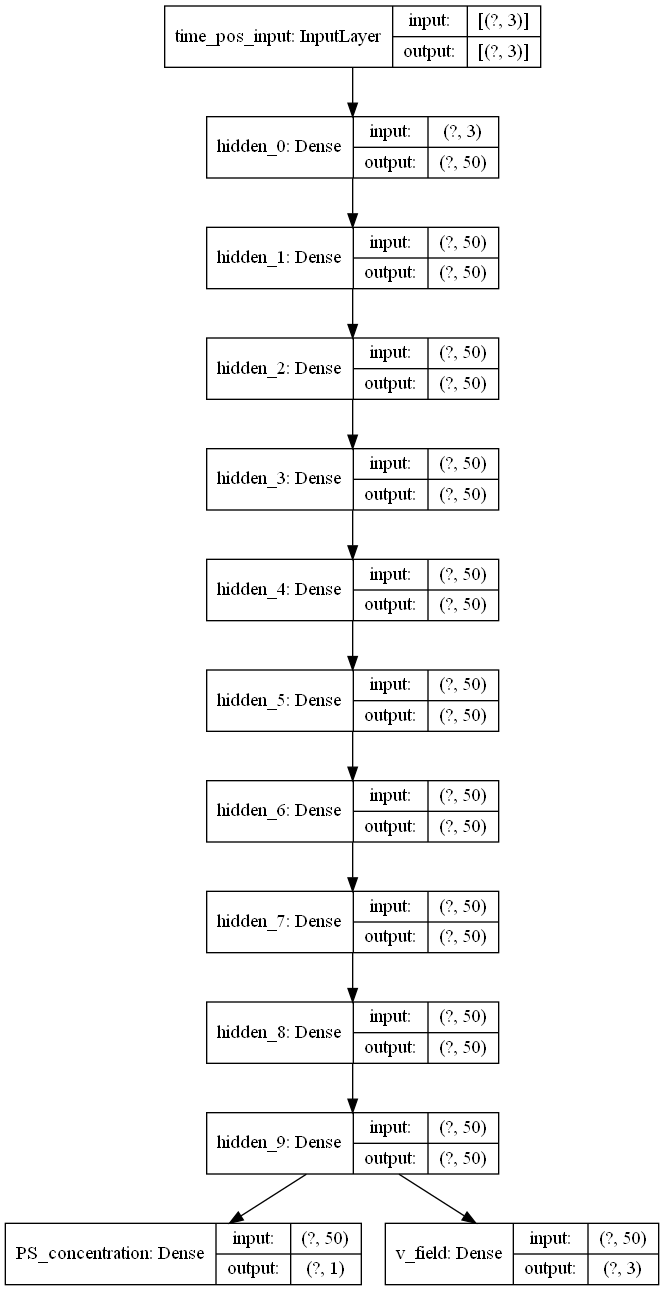

In [52]:
keras.utils.plot_model(model, f"{model.name}.png", show_shapes=True)

In [21]:
n = 10 # number of samples
m = 3  # number of features
x = tf.ones((n,m))

# Graph evaluation of NN
est_c, NS_residual = tf.function(model)(x)
print(est_c)
print(NS_residual)

tf.Tensor(
[[-0.5319765]
 [-0.5319765]
 [-0.5319765]
 [-0.5319765]
 [-0.5319765]
 [-0.5319765]
 [-0.5319765]
 [-0.5319765]
 [-0.5319765]
 [-0.5319765]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[-0.44030723  0.8288637   0.7010397   0.97604585]
 [-0.44030723  0.8288637   0.7010397   0.97604585]
 [-0.44030723  0.8288637   0.7010397   0.97604585]
 [-0.44030723  0.8288637   0.7010397   0.97604585]
 [-0.44030723  0.8288637   0.7010397   0.97604585]
 [-0.44030723  0.8288637   0.7010397   0.97604585]
 [-0.44030723  0.8288637   0.7010397   0.97604585]
 [-0.44030723  0.8288637   0.7010397   0.97604585]
 [-0.4403073   0.8288637   0.7010397   0.97604585]
 [-0.44030735  0.8288637   0.70103973  0.97604585]], shape=(10, 4), dtype=float32)


In [6]:
# Gradient tape can be run on this to calculate gradients required for lift and drag forces
get_trained_vel_prs = keras.Model(
    inputs  = init_model.inputs,
    outputs = trained_velocity,
    name    = "2D_PST_VPL"
)

# u, v, p = (vel_prs_array := get_trained_vel_prs(x))[:,0], vel_prs_array[:,1], vel_prs_array[:,2]

# Graph evaluation of NN
vel_prs_array = tf.function(get_trained_vel_prs)(x)
u, v, p = vel_prs_array[:,0], vel_prs_array[:,1], vel_prs_array[:,2]
print(u)
print(v)
print(p)

tf.Tensor(
[0.2880992 0.2880992 0.2880992 0.2880992 0.2880992 0.2880992 0.2880992
 0.2880992 0.2880992 0.2880992], shape=(10,), dtype=float32)
tf.Tensor(
[-0.4684223  -0.4684223  -0.4684223  -0.4684223  -0.4684223  -0.4684223
 -0.4684223  -0.4684223  -0.46842232 -0.46842232], shape=(10,), dtype=float32)
tf.Tensor(
[0.18756919 0.18756919 0.18756919 0.18756919 0.18756919 0.18756919
 0.18756919 0.18756919 0.18756919 0.18756919], shape=(10,), dtype=float32)


In [7]:
# model.save(f"C:/UserTemp/models/{model.name}_model_{datetime.now().strftime('%y.%m.%d.%H.%M.%S')}")
# model.save_weights(f"C:/UserTemp/model_weights/{model.name}_model_{datetime.now().strftime('%y.%m.%d.%H.%M.%S')}")